In [ ]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib 
from matplotlib import pyplot as plt 
import gurobipy as gp
from gurobipy import GRB


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score



In [ ]:
def load_data():
    df_wind = pd.read_csv("Processed_data.csv",index_col= 0)
    prices_df = pd.read_csv("Prices_processed.csv",index_col =0).round(1)
    df_features= pd.read_csv("Feature_selected.csv",index_col=0)

    Wind_data = df_wind.Actual
    
    
    X_train, X_test, y_train, y_test, prices_train ,prices_test= train_test_split(df_features, Wind_data,prices_df ,test_size=0.25, shuffle = False)
            
    return  X_train, X_test, y_train, y_test, prices_train ,prices_test


In [ ]:
def clust(X_train, X_test, y_train, y_test,n_cluster):
    
    """
    Input training data and how many clusters should be made 
    Kmeans clustering is used. Could improve model by figuring out how many clusters fit the best by using silhoutte value 
    
    Predicts the cluster of the the values, and all training and test data is seperated into a dataframe with their respective cluster 
    
  
    
    return: labels of train and test set, training and test data of each cluster 
    
    """
    #kmeans estimator 
    kmeans = KMeans(n_clusters=n_cluster).fit(X_train)
    #Getting unique labels
    label_train = kmeans.labels_
    kmeans_pred = kmeans.predict(X_test)
    
    # Get the unique cluster labels
    u_labels_train = np.unique(label_train)
    u_labels_test = np.unique(kmeans_pred)
    
    
    
    fig, axes = plt.subplots(2, 2, sharex=True)
    
    #Cluster of time series training  
    for (i,ax) in enumerate(axes.flatten()):
        ax.set_title("Cluster " + str(i+1))
        ax.set_ylabel("Wind Power")
        ax.set_xlabel("Time")
        ax.plot(X_train.index, y_train, 'r-',label = "orig")
        ax.plot(X_train[label_train == i].index, y_train[label_train == i], 'g-',label = "Cluster")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.suptitle('Wind production seperated into clusters vs time: Training Set ', fontsize=16)
    fig.tight_layout()
    plt.show()
    
    
    fig, axes = plt.subplots(2, 2, sharex=True)
    #Cluster of time series 
    for (i,ax) in enumerate(axes.flatten()):
        ax.set_title("Cluster " + str(i+1))
        ax.set_ylabel("Wind Power")
        ax.set_xlabel("Time")
        ax.plot(X_test.index, y_test, 'r-',label = "orig")
        ax.plot(X_test[kmeans_pred == i].index, y_test[kmeans_pred == i], 'g-',label = "Cluster")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.suptitle('Wind production seperated into clusters vs time :Test Set ', fontsize=16)
    fig.tight_layout()
    plt.show()
    
    
 
    
    plt.figure()
    plt.title("Clusted Time series")
    plt.ylabel("Wind Power")
    plt.xlabel("Time")
    plt.scatter(X_train.index, y_train,label = "orig",alpha=0.4)
    for i in u_labels_train:
        plt.scatter(X_train[label_train == i].index , y_train[label_train == i],label = i,alpha=0.1 )
    plt.legend()
    plt.show()
    
    
    # Create a list of indices at which to split the array
    split_indices_train = []
    split_indices_test = []
    clusted_dfs_train = []
    clustered_y_train = []
    clusted_dfs_test = []
    clustered_y_test = []
    
    
     #save each train cluster into their own dataframe  and to list 
    for i in range(len(u_labels_train)):
        split_indices_train.append(np.where(label_train == i)[0])
        clusted_dfs_train.append( X_train.iloc[split_indices_train[i]].reset_index(drop=True))
        clustered_y_train.append(y_train.iloc[split_indices_train[i]].reset_index(drop=True))
        
        
     #save each test cluster into their own dataframe  and to list 
    for i in range(len(u_labels_test)):
       
        split_indices_test.append(np.where(kmeans_pred == u_labels_test[i])[0])
        clusted_dfs_test.append(X_test.iloc[split_indices_test[i]])
        clustered_y_test.append(y_test.iloc[split_indices_test[i]])
    
    
    return label_train,u_labels_test,clusted_dfs_train,clustered_y_train,clusted_dfs_test,clustered_y_test

In [ ]:
def clusted_reg(label_train,u_labels_test,clusted_dfs_train,clustered_y_train,clusted_dfs_test,clustered_y_test):
    
    """
    Input training data seperated into per cluster
    A normall regression is trained on the clusted data 
    
    When all clusters have been trained and predicted with its best estimator, 
    all the predictions are recombined into one set with their orignial index so time is maintained
    
    return: recombined test data, best MSE of all models, best r-score of all models 
    """
    
    #Save predictions 
    y_pred_list = []
    y_pred_df = []
    
    r_scores = np.empty(len(u_labels_test))
    mse_scores = np.empty(len(u_labels_test))
    param_grid = {'fit_intercept':[True,False]}
    #Each cluster is trained individually and best is kept 
    
    fig, axes = plt.subplots(2, 2, sharex=True)
    
    
    for (k,ax) in enumerate(axes.flatten()):

        print(k)
        x_train = clusted_dfs_train[u_labels_test[k]]
        y_train = clustered_y_train[u_labels_test[k]]
        
        x_test =clusted_dfs_test[k]
        y_test = clustered_y_test[k]
        
        
        reg = LinearRegression()
        #Each cluster is trained individually and best is kept 
        regCV  = GridSearchCV(estimator = reg, cv=TimeSeriesSplit(n_splits=5),param_grid = param_grid, return_train_score = True)
       
        
        regCV.fit(x_train, y_train)
        best_reg = regCV.best_estimator_
        
        # Making predictions
        y_pred_sk = best_reg.predict(x_test)
        #Save to list 
        y_pred_list.append(y_pred_sk)
        y_pred_df.append(pd.DataFrame(y_pred_sk,index=y_test.index))
        
        print('MSE:',mean_squared_error(y_test,y_pred_sk))
        print('R^2:', r2_score(y_test, y_pred_sk, force_finite=False))
        
        r_scores[k] = r2_score(y_test, y_pred_sk, force_finite=False)
        mse_scores[k] = mean_squared_error(y_test,y_pred_sk)
        
        
        
        ax.set_title("Cluster " + str(k+1))
        ax.set_ylabel("Wind Power")
        ax.set_xlabel("Time")
        ax.plot(x_test.index, y_test, 'r-',label = "Orig",alpha=0.7)
        ax.plot(x_test.index, y_pred_sk, 'g-',label = "Cluster",alpha=0.6)

    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.suptitle('Regression on Wind Forecast', fontsize=16)
    fig.tight_layout()
    plt.show()
        
    """
        plt.figure()
        plt.title("RFR Regression on Cluster "+str(k)+" on Wind Forecast")
        plt.ylabel("Wind Power")
        plt.xlabel("Time")
        plt.scatter(x_test.index, y_test)
        plt.scatter(x_test.index, y_pred_sk, c="red")
        plt.show()
    """
    
    
    Clust_reg_combined = pd.concat(y_pred_df).squeeze()
    
    
    return Clust_reg_combined,r_scores,mse_scores

In [ ]:
def clusted_rfr(label_train,u_labels_test,clusted_dfs_train,clustered_y_train,clusted_dfs_test,clustered_y_test): 
    
    """
    Input training data seperated into per cluster
    A Random Forest regression is trained on the clusted data 
    
    When all clusters have been trained and predicted with its best estimator, 
    all the predictions are recombined into one set with their orignial index so time is maintained
    
    return: recombined test data, best MSE of all models, best r-score of all models 
    """
    
    #Estimator paramters to be checked for best 
    rfr = RandomForestRegressor()
    param_grid = {
        'max_depth': [3,5,8,10],
        'criterion' :['squared_error'],
        'n_estimators': [10,20,40,]
    } 
    
    
    y_pred_list = []
    y_pred_df = []
    
    r_scores = np.empty(len(u_labels_test))
    mse_scores = np.empty(len(u_labels_test))
    fig, axes = plt.subplots(2, 2, sharex=True)
    #Each cluster is trained individually and best is kept 
    for (k,ax) in enumerate(axes.flatten()):

        x_train = clusted_dfs_train[u_labels_test[k]]
        y_train = clustered_y_train[u_labels_test[k]]
        
        x_test =clusted_dfs_test[k]
        y_test = clustered_y_test[k]
        
        
        rfrCV  = GridSearchCV(estimator = rfr, cv=TimeSeriesSplit(n_splits=5),param_grid = param_grid, return_train_score = True)
        rfrCV.fit(x_train, y_train)
        best_rfr = rfrCV.best_estimator_
        
        y_pred_sk = best_rfr.predict(x_test)
        
        #Save to list 
        y_pred_list.append(y_pred_sk)
        y_pred_df.append(pd.DataFrame(y_pred_sk,index=y_test.index))
        
        print('MSE:',mean_squared_error(y_test,y_pred_sk))
        print('R^2:', r2_score(y_test, y_pred_sk, force_finite=False))
        
        r_scores[k] = r2_score(y_test, y_pred_sk, force_finite=False)
        mse_scores[k] = mean_squared_error(y_test,y_pred_sk)
        
       
        ax.set_title("Cluster " + str(k+1))
        ax.set_ylabel("Wind Power")
        ax.set_xlabel("Time")
        ax.plot(x_test.index, y_test, 'r-',label = "Orig",alpha=0.7)
        ax.plot(x_test.index, y_pred_sk, 'g-',label = "Cluster",alpha=0.6)
        ax.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred_sk)), (1, 0))
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.suptitle('Random forrest on Wind Forecast', fontsize=16)
    fig.tight_layout()
    plt.show()
    
    #all clusters recombined , index maintained 
    Clust_rfr_combined = pd.concat(y_pred_df).squeeze()
    
    return Clust_rfr_combined,r_scores,mse_scores

In [ ]:
def opt_model(pred,Windspeed,prices):
    
    """
    Input:
        Forecast of Wind t
        Actual Wind t
        Prices of period t

    
    Computes the optimal bidding with our prediction of wind production 
    The comparison between our forecast and actual is calculated through solving the opt problem with their respective values
    and comparing obj values. 

    
    return:
        P_DA : Bid in Day ahead market 
        Obj_val: Objective value of opt problem 
        p_E_up_list : Balancing Power up 
        p_E_down_list : Balancing Power down 
        
    """
    
    forecast_wind = pred.values
    Windspeed = Windspeed.values
    Time = len(Windspeed)
    T = range(Time)

    DA_prices = prices["SpotPriceEUR"].to_numpy()
    Up_prices = prices["Up-regulating_price"].to_numpy()
    Down_prices = prices["Down-regulating_price"].to_numpy()
    Capacity = 1 

    psi_up= Up_prices -DA_prices
    psi_down = DA_prices- Down_prices

    model_opt = gp.Model("Step1_A")
    p_DA_A = model_opt.addVars(Time,lb=0,name ="Day Ahead bid")
    p_delt = model_opt.addVars(Time,lb=-gp.GRB.INFINITY,ub=gp.GRB.INFINITY,name="delta diff.")

    p_E_up = model_opt.addVars(Time,lb =-1,ub=0, name ="Up regulation")
    p_E_down = model_opt.addVars(Time,lb =0,ub=1, name ="Down regulation")
    
    #Objective value 
    model_opt.setObjective(
    gp.quicksum(p_DA_A[t]*DA_prices[t] 
            + (Up_prices[t] *  p_E_up[t] + Down_prices[t] *  p_E_down[t]) for t in T )
            ,gp.GRB.MAXIMIZE)

    
    model_opt.addConstrs(
    (p_DA_A[t] <= Capacity
    for t in T
    ), name ="capacity constraint "
    )

    model_opt.addConstrs(
    (
    p_delt[t] == Windspeed[t]-p_DA_A[t]
    for t in T
    ), name ="Delta of bid and production "
    )

    model_opt.addConstrs(
    (
    p_delt[t] == p_E_up[t] + p_E_down[t] +(forecast_wind[t]-Windspeed[t])
    for t in T
    ), name="Connecting delta to up and down regulation"
    )
    

    model_opt.setParam('OutputFlag', False )
    model_opt.optimize()
    if model_opt.status == GRB.OPTIMAL:
        obj_val =  model_opt.objVal 
        #print("Revenue =", "{:.2f}".format(model_opt.objVal))
        #print("Offering Strategy =", ["{:.2f}".format(p_DA_A[t].x) for t in T])
        #print("Imbalance Power =", ["{:.2f}".format(p_delt[t].x) for t in T])
        #print("Real Power  =", ["{:.2f}".format(Windspeed[t]) for t in T])
        P_DA = [p_DA_A[t].x for t in T]
        obj_vals_hour ={t: p_DA_A[t].x*DA_prices[t] - (Up_prices[t] *  p_E_up[t].x + Down_prices[t] *  p_E_down[t].x) for t in T }

        p_E_up_list =[p_E_up[t].x for t in T]
        p_E_down_list = [p_E_down[t].x for t in T]


    else:
        print("Optimization was not successful")

    return P_DA,obj_val,obj_vals_hour

In [ ]:

def balancing_revenue(P_DA_bid, p_real, prices):
    
    """
    
    Input: 
    Bids made for Day ahead market
    The actual wind production 
    The prices for test set
    
    We calculate the realization of our day ahead bid in the market
    
    Output: 
        
    Revenue: Our actual money gained
    
    Up and down regulation made by our Day ahead bid
    
    """
    
    Time = len(P_DA_bid)
    T = range(Time)
    p_real = p_real.to_numpy()
    
    if isinstance(P_DA_bid,pd.core.series.Series):
        P_DA_bid = P_DA_bid.to_numpy()
    

    DA_prices = prices["SpotPriceEUR"].to_numpy()
    Up_prices = prices["Up-regulating_price"].to_numpy()
    Down_prices = prices["Down-regulating_price"].to_numpy()
    
    p_up = np.empty(Time)
    p_down = np.empty(Time)
 
    for t in T:
        if p_real[t] <= P_DA_bid[t] :
            p_up[t] = p_real[t] -P_DA_bid[t]
        else:
            p_up[t] = 0
        if p_real[t] > P_DA_bid[t] :
            p_down[t] = p_real[t] - P_DA_bid[t]
        else:
            p_down[t] = 0
    Revenue = np.dot(P_DA_bid,DA_prices) + np.dot(p_up,Up_prices) + np.dot(p_down,Down_prices)
    
    return Revenue, p_up,p_down

# Main function below

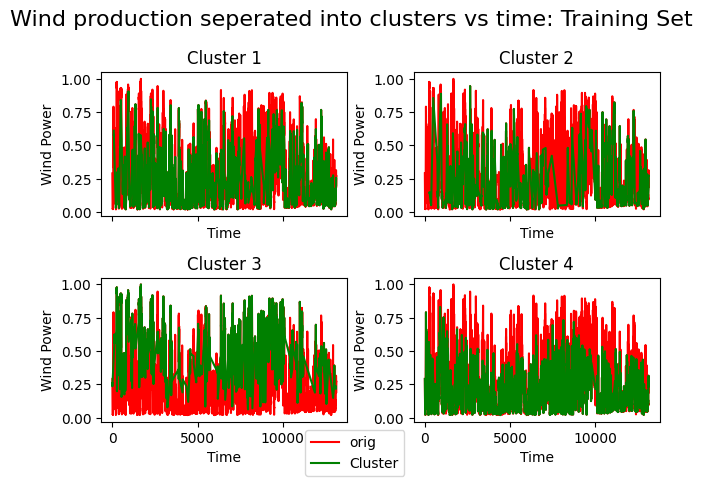

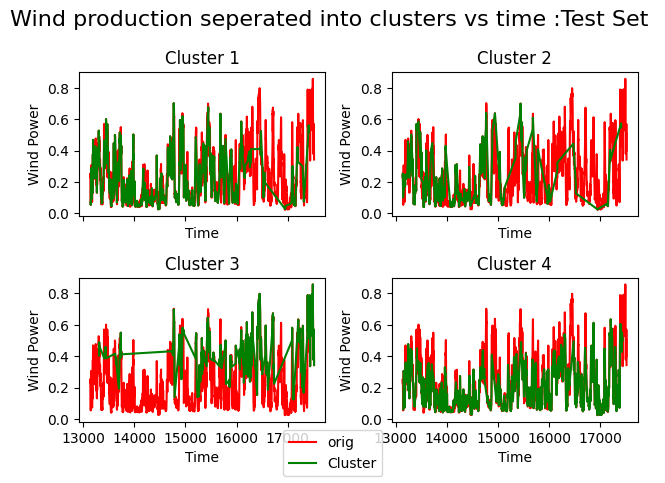

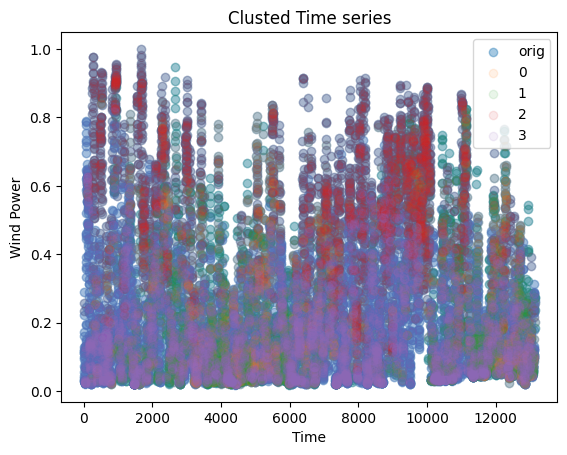

0
MSE: 0.006164922687628284
R^2: 0.740491459855203
1
MSE: 0.004913669253037814
R^2: 0.7844971974565074
2
MSE: 0.012338622105510283
R^2: 0.46300776156055035
3
MSE: 0.0057970024581446445
R^2: 0.5912459991711603


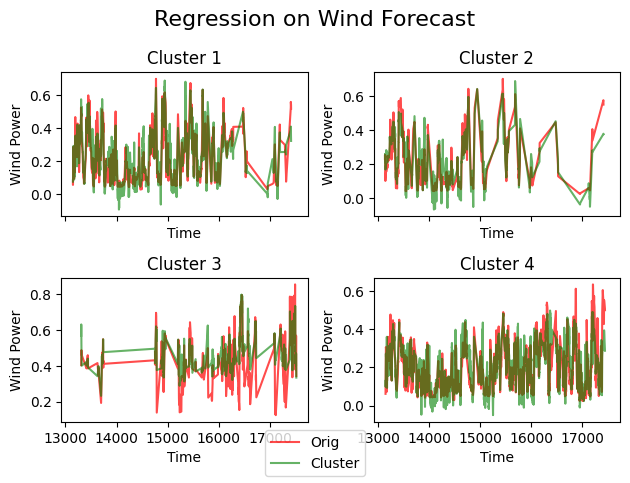

MSE: 0.006001932792394619
R^2: 0.7473524169042385
MSE: 0.004777050339112784
R^2: 0.7904890046610908
MSE: 0.012855675716227949
R^2: 0.44050494289585673
MSE: 0.006805896733617984
R^2: 0.5201075833277026


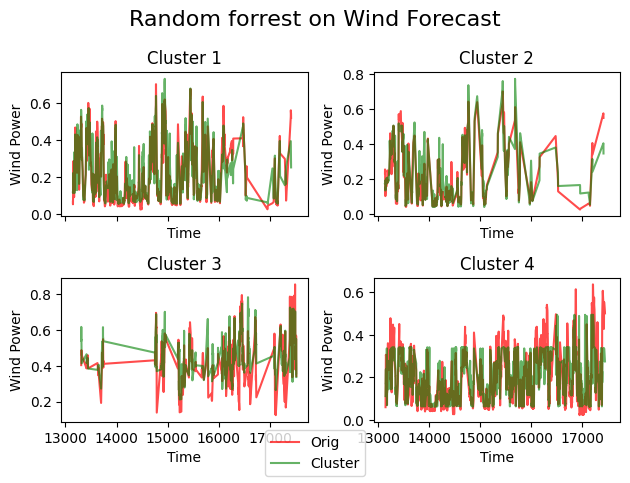

Restricted license - for non-production use only - expires 2024-10-28


GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [ ]:
   
X_train, X_test, y_train, y_test , X_prices,y_prices  =  load_data()
n_cluster = 4


    
label_train,u_labels_test,clusted_dfs_train,clustered_y_train,clusted_dfs_test,clustered_y_test=clust(X_train, X_test, y_train, y_test,n_cluster)


Clust_reg_combined,r_scores_reg,mse_scores_reg = clusted_reg(label_train,u_labels_test,clusted_dfs_train,clustered_y_train,clusted_dfs_test,clustered_y_test)
         
    
Clust_rfr_combined,r_scores_rfr,mse_scores_rfr = clusted_rfr(label_train,u_labels_test,clusted_dfs_train,clustered_y_train,clusted_dfs_test,clustered_y_test)
    
score_reg = r2_score(y_test, Clust_reg_combined)
score_rfr =r2_score(y_test, Clust_rfr_combined)

#Optimal value of optimization problem 
#Input for optimziation is forecast , actual and prices. For perfect foresight forecast = actual
P_DA_opt,obj_val_opt,obj_vals_hour_opt= opt_model(y_test,y_test,y_prices)

#Clustered regression 
P_DA_reg,obj_val_reg,obj_vals_hour_reg= opt_model(Clust_reg_combined,y_test,y_prices)

#Clustered randomforest 
P_DA_rfr,obj_val_rfr,obj_vals_hour_rfr= opt_model(Clust_rfr_combined,y_test,y_prices)

#Calculate the actual revenue 

Revenue_reg, p_up_reg,p_down_reg = balancing_revenue(P_DA_reg,y_test,y_prices)

Revenue_rfr, p_up_rfr,p_down_rfr = balancing_revenue(P_DA_rfr,y_test,y_prices)

percent_reg = Revenue_reg/obj_val_opt
percent_rfr= Revenue_rfr/obj_val_opt
print("Random Forest %",percent_rfr)
print("Regression %",percent_reg)


plt.figure(figsize=(10, 6))
plt.scatter(y_test,Clust_reg_combined, c='b', label='Fitted Data',alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values : Clusted Regression')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_test,Clust_rfr_combined, c='b', label='Fitted Data',alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values: Clusted RFR')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=538942fa-4593-4d1a-b90d-2d23669fe78c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>